# Fraud Detection in Electricity and Gas Consumption.

An electricity and gas distribution company STEG has suffered huge losses approximately 200 million Tunisian Dinars due to fraudulent manipulation of meters by its customers. We will use the data the company has on the billing history of its customers to detect fradulent activities.

### *DATA*
* For training and testing, there are two datasets: client data and the clients invoice.


### *Variable definitions*

#### *Client*:

* Client_id: Unique id for client
* District: District where the client is
* Client_catg: Category client belongs to
* Region: Area where the client is
* Creation_date: Date client joined
* *Target*: fraud:1 , not fraud: 0

#### *Invoice data*

* Client_id: Unique id for the client
* Invoice_date: Date of the invoice
* Tarif_type: Type of tax
* Counter_number:
* Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, etc.
* Counter_code:
* Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
* Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
* Consommation_level_1: Consumption_level_1
* Consommation_level_2: Consumption_level_2
* Consommation_level_3: Consumption_level_3
* Consommation_level_4: Consumption_level_4
* Old_index: Old index
* New_index: New index
* Months_number: Month number
* Counter_type: Type of counter


<a id="cont"></a>

## **Table of Contents**

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<!-- <a href=#seven>7. Model Explanations</a> -->

 <a id="one"></a>
## **1.Importing Packages**
<a href=#cont>Back to Table of Contents</a>

##### Using the *import* statement we are going to import all the usefull packages neccessary for the completion of this project.

In [1]:
# # Library for Google Colab
# from google.colab import drive
# from scipy import stats
# drive.mount('/content/drive')

In [2]:
# Base Libraries
import re
import time
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import pickle
#display all dataframe columns in df
pd.options.display.max_columns = None
#display long string in datafame
pd.options.display.max_colwidth = None


# Preprocessing Libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Libraries for Imbalanced data correction
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE
from collections import Counter

# Libraries for Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree, svm
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score, f1_score, confusion_matrix, recall_score, precision_score

# Library for visualization
import itertools
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

<a id="two"></a>
## **2. Loading Data**
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

##### Here we load the client and invoice comma seperated value files contained in both the train and test dataset into a pandas DataFrame.

In [3]:
#load training data
client_train_df = pd.read_csv('train/client_train.csv') 
invoice_train_df = pd.read_csv('train/invoice_train.csv') 

#load testing data
client_test_df = pd.read_csv('test/client_test.csv') 
invoice_test_df = pd.read_csv('test/invoice_test.csv') 

<a id="three"></a>
## **3. Exploratory Data Analysis (EDA)**
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### **Basic Analysis**

Here we we look at:
* The first five data points for each dataset
* The shape of our data: how many columns and rows are in each dataframe
* The data types for each column
* Check if there are null values 

Check the first five datapoints for each set.

In [4]:
client_train_df.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [5]:
invoice_train_df.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


Lets check the shape of each set.

In [6]:
#train data
client_train_df.shape

(135493, 6)

In [7]:
#train data
invoice_train_df.shape

(4476749, 16)

In [8]:
#test data
client_test_df.shape

(58069, 5)

In [9]:
#test data
invoice_test_df.shape

(1939730, 16)

### *Train data*

The client train dataframe has 135,493 rows and 6 columns while the invoice train dataframe has 4,476,749 rows and 16 columns. 

### *Test data*

The client test dataframe has 58,069 rows and 5 columns. This is one less column than the client train dataframe. The invoice test dataframe on the other hand has 1,939,730 rows and 16 columns. 

Now lets confirm the missing column in the *client_test* dataframe.

In [10]:
#basic info and datatypes 
client_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [11]:
client_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   disrict        58069 non-null  int64 
 1   client_id      58069 non-null  object
 2   client_catg    58069 non-null  int64 
 3   region         58069 non-null  int64 
 4   creation_date  58069 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.2+ MB


* We can observe that the missing column from the client **test** dataframe is the **target** column literally. This is the column that our model is supposed to predict. 
* There are two datatypes: int64 and object.
* Our target column is of the data type float64.

Lets see if we could find the link between the client and invoice dataset.

In [12]:
client_train_df.nunique()

disrict               4
client_id        135493
client_catg           3
region               25
creation_date      8088
target                2
dtype: int64

In [13]:
invoice_train_df.nunique()

client_id               135493
invoice_date              8275
tarif_type                  17
counter_number          201893
counter_statue              16
counter_code                42
reading_remarque             8
counter_coefficient         16
consommation_level_1      8295
consommation_level_2     12576
consommation_level_3      2253
consommation_level_4     12075
old_index               155648
new_index               157980
months_number             1370
counter_type                 2
dtype: int64

* The number of unique *client_id* is similar for both datasets. We will therefore map the client dataset onto the invoice dataset so that we can be able to analyse our dataset with the target column present. 
* From the counter_type column we can observe that there are only two types of counters.

In [14]:
invoice_train_df['counter_type'].unique()

array(['ELEC', 'GAZ'], dtype=object)

* The types of counter are **ELEC** and **GAZ**. These represent electricity and gas counters repectively.

Now lets merge the client and invoice dataset to enable further exploration.

In [15]:
#merge the two train dataframes
train_df= pd.merge(invoice_train_df, client_train_df, how='inner', on = 'client_id')
#merge the two test dataframes
test_df= pd.merge(invoice_test_df, client_test_df, how='inner', on = 'client_id')

After merging the two dataframes, we expect:
* The number of rows for the new train dataframe to be the same as the number of rows from the invoice train dataframe i.e 4476749
* The number of columns to be a sum of the columns from the two dataframes i.e 21

We can confirm this by using the .shape method below:

In [16]:
#check the shape of the new train dataframe
train_df.shape 

(4476749, 21)

In [17]:
#check the first five rows of our train data
train_df.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC,60,11,101,31/12/1994,0.0
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC,60,11,101,31/12/1994,0.0
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC,60,11,101,31/12/1994,0.0
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC,60,11,101,31/12/1994,0.0
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC,60,11,101,31/12/1994,0.0


#### **Advanced Analysis**

Here we are going to examine:
* The target column
* Which region had the highest number of fraud cases
* Which district had the highest number of fraud cases
* Which year, month and day recorded the highest number of fraud cases
* Which counter type is more subject to tempering

#### **Examine the target column**

Count unique values

In [18]:
train_df['target'].unique()

array([0., 1.])

There are two classes in our data: 0 and 1

Data amount provided per class

In [19]:
train_df['target'].value_counts()

0.0    4123637
1.0     353112
Name: target, dtype: int64

This shows the amount of data provided for each class. We can observe that  fraudulent cases (1.0) are significantly less than non-fradulent cases(0.0). This can be better shown in a bar graph:

Text(0.5, 1.0, 'Percentage data for each class')

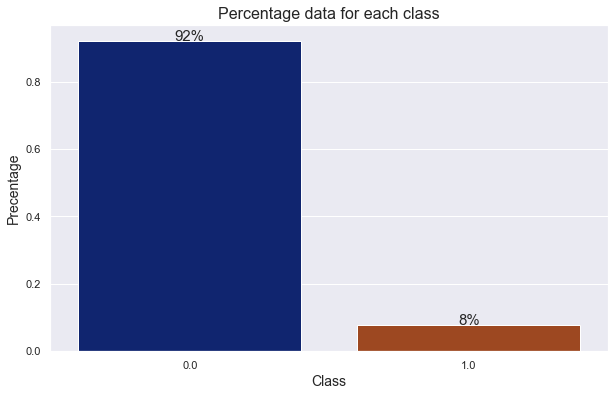

In [20]:
#How many data samples are provided for each class
plt.figure(figsize=(10,6))
g = sns.barplot(train_df['target'], train_df['target'], palette='dark', estimator=lambda x: len(x) / len(train_df))

for p in g.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    g.text(x+width/2, 
           y+height, 
           '{:.0%}'.format(height), 
           horizontalalignment='center',fontsize=15)
    
#Setting the labels
plt.xlabel('Class', fontsize=14)
plt.ylabel('Precentage', fontsize=14)
plt.title('Percentage data for each class', fontsize=16)


* The bar graph confirms a severe **class imbalance**. 
* **Class imbalance** is where there are very few cases reperesenting a given class.
* This can affect our model's ability to accurately predict fradulent cases because it has seen few such cases. 

* During model evaluation we will asses our model's ability to predict these fradulent cases. If the accuracy is low, then we can upsample our data or find other methods of dealing with class imbalance.


#### **Which region had the highest fraud cases**

First we separate fraud cases from non-fradulent cases.

In [21]:
fraud = train_df[train_df['target']==1]
non_fraud = train_df[train_df['target']==0]

Group each cases by regions.

In [22]:
fraud_region= fraud[['region','target']].groupby('region').count()
nonfraud_region= non_fraud[['region','target']].groupby('region').count()

Plot region by fraud cases.

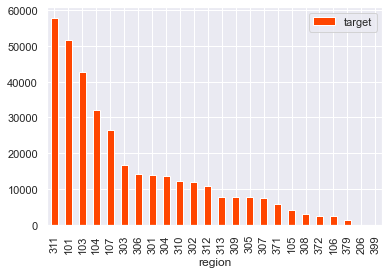

In [23]:
fraud_region.sort_values('target', ascending=False).plot(kind='bar', color='orangered')
plt.show()

* We will focus on the fraud cases since they are the ones giving the company loses
* Out of 25 regions, region 311 has the highest number of fraud cases followed by 101.

#### **Which district had the highest fraud cases**


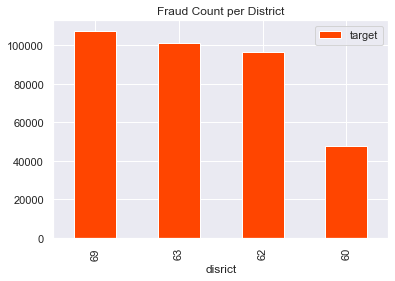

In [24]:
fraud_district= fraud[['disrict','target']].groupby('disrict').count()
#plot region by fraud cases
fraud_district.sort_values('target', ascending=False).plot(kind='bar', color='orangered')
plt.title('Fraud Count per District')
plt.show()

Out of the 4 districts, district 69 has the highest number of fraud cases cases.

#### **Which Year recorded the highest number of fraud cases**

Convert date to a datatype we can use to plot.

In [25]:
fraud['time'] = pd.to_datetime(fraud['invoice_date'], format='%Y-%m-%d %H:%M:%S')

#split datetime to year, month, day, hour
fraud['year'] = pd.DatetimeIndex(fraud['time']).year
fraud['month'] = pd.DatetimeIndex(fraud['time']).month
fraud['day'] = pd.DatetimeIndex(fraud['time']).day

Plot region by fraud cases

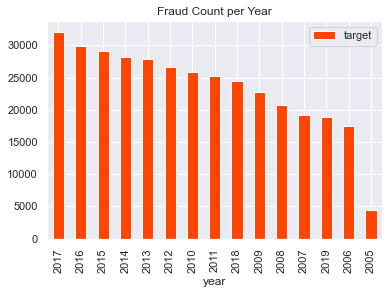

In [26]:
year_df = fraud[['year','target']].groupby('year').count()

year_df.sort_values('target', ascending=False).plot(kind='bar', color='Orangered')
plt.title("Fraud Count per Year")
plt.show()

Of the data provided for the 15 years, the year 2017 had the highest number of fradulent cases, while 2005 had the least cases.

#### **Which month recorded the highest number of fraud cases**

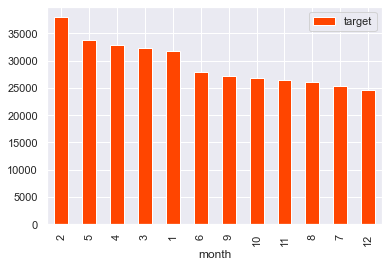

In [27]:
month_df = fraud[['month','target']].groupby('month').count()
#plot region by fraud cases
month_df.sort_values('target', ascending=False).plot(kind='bar', color='Orangered')
plt.show()

The first five months of the year recorded the highest number of fraud cases with february leading the pack.

#### **Which days recorded the highest number of fraud cases**

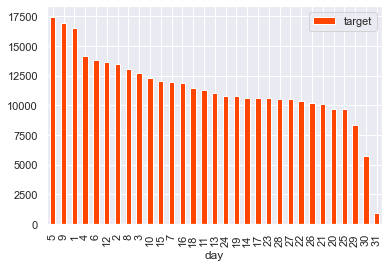

In [28]:
day_df = fraud[['day','target']].groupby('day').count()
#plot region by fraud cases
day_df.sort_values('target', ascending=False).plot(kind='bar', color='Orangered')
plt.show()

During the beggining of the month, there are usually more fraud cases than at the end of the month

#### **Which Counter recorded the highest number of fraud cases**

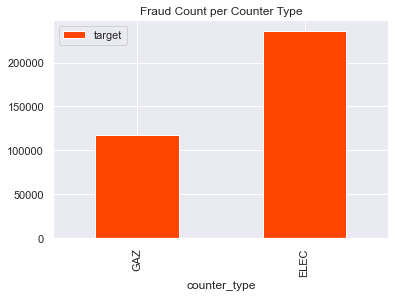

In [29]:
type_df = fraud[['counter_type','target']].groupby('counter_type').count()
#plot region by fraud cases
type_df.sort_values('counter_type', ascending=False).plot(kind='bar', color='Orangered')
plt.title('Fraud Count per Counter Type')
plt.show()

Electricity counters are more subject to theft than gas counters.

<a id="four"></a>
## **4. Data Engineering**
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

At this stage we will be perfoming some transformations, informed by the EDA, on the features in the datasets in preparation for modelling.
This will be done in the following steps;

* Changing the data type of some features
* Splitting the data into training and validation sets
* Scaling of the numerical features
* Encoding the non-numerical features 
* Resampling of the data set to handle the class imbalance in the target feature

### 4.1 Changing the data type of some features
Here we will change the data type of some of the categorical features, wrongly saved as numerical into object data types and vice versa, and also transform the date features from numerical into datetime format.

First lets look at train and test dataset, and confirm if they all have the same datatypes

In [30]:
for col in test_df.columns:
    if test_df[col].dtype != train_df[col].dtype:
        print('Column Name:',col,'\n''Train Set:',train_df[col].dtype, 'Test Set:',test_df[col].dtype )

Column Name: counter_statue 
Train Set: object Test Set: int64


Okay, *counter_statue* is the only variable in both train and test dataset having different datatypes lets fing out why?

In [31]:
test_df['counter_statue'].value_counts().index

Int64Index([0, 1, 5, 4, 3, 2], dtype='int64')

In [32]:
train_df['counter_statue'].value_counts().index

Index([0, 1, '0', 5, 4, '1', 3, '5', 2, '4', 46, 'A', 618, 769, 269375, 420], dtype='object')

From above analysis we can see that in the test dataset *counter_statue* only have values between 0 & 5, which are all integers, but the train dataset has both numerical and string values.

* Transform the feature counter_statue in train_df to integer type simalar to the one in the test_df. 
* To achieve this there's need to eliminate some wrongly entered values in it like 'A'
* Then replace the values with a count less than 100 with the mode value which is 0. 
* There should be 5 unique values for the statues according to the documentation

In [33]:
# s = train_df['counter_statue'].value_counts()
# train_df['counter_statue'] = np.where(train_df['counter_statue'].isin(s.index[s < 100]), 0, train_df['counter_statue'])

counter_list = [46, 'A', 618, 769, 269375, 420]
for num in counter_list:
    train_df['counter_statue'] = np.where(train_df['counter_statue'] == num, 0, train_df['counter_statue'])

In [34]:
train_df['counter_statue'].value_counts() 

0    4347007
1      73496
0      32048
5      20495
4       2706
1        540
3        258
5        144
2         32
4         23
Name: counter_statue, dtype: int64

There's clearly a change in the value_counts.

Now we can change the datatype.

In [35]:
dates=['creation_date', 'invoice_date'] #features to be changed to datetime
objs = ['disrict','region']  #features to be changed to categorical
integer = ['counter_statue','target'] #features to be changed to numerical

For ease, lets create a function that transforms our features to the correct datatype and also create new features from the dates columns.

In [36]:
def DT_transform(df):
  """This function takes in a dataframe transform the data type of columns in the objs and dates list, 
  and also creates new columns of day, month & year from the dates columns"""
  for col in df:
    if col in objs:
      df[col] = df[col].astype(str)
    elif col in dates:
      df[col] = pd.to_datetime(df[col])
      df[col+"_"+"year"]=pd.DatetimeIndex(df[col]).year
      df[col+"_"+"month"]=pd.DatetimeIndex(df[col]).month
      df[col+"_"+"day"]=pd.DatetimeIndex(df[col]).day
    elif col in integer:
      df[col] = df[col].astype(int)
  

Lets Transform the train and test dataframe using the *DT_transform* function

In [37]:
#transform the train dataframe
DT_transform(train_df)

#transform the test data frame
DT_transform(test_df)

Lets have a view of the result.

In [38]:
train_df.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target,invoice_date_year,invoice_date_month,invoice_date_day,creation_date_year,creation_date_month,creation_date_day
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC,60,11,101,1994-12-31,0,2014,3,24,1994,12,31
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC,60,11,101,1994-12-31,0,2013,3,29,1994,12,31
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC,60,11,101,1994-12-31,0,2015,3,23,1994,12,31
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC,60,11,101,1994-12-31,0,2015,7,13,1994,12,31
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC,60,11,101,1994-12-31,0,2016,11,17,1994,12,31


In [39]:
train_df.shape

(4476749, 27)

In [40]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1939730 entries, 0 to 1939729
Data columns (total 26 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   tarif_type            int64         
 3   counter_number        int64         
 4   counter_statue        int32         
 5   counter_code          int64         
 6   reading_remarque      int64         
 7   counter_coefficient   int64         
 8   consommation_level_1  int64         
 9   consommation_level_2  int64         
 10  consommation_level_3  int64         
 11  consommation_level_4  int64         
 12  old_index             int64         
 13  new_index             int64         
 14  months_number         int64         
 15  counter_type          object        
 16  disrict               object        
 17  client_catg           int64         
 18  region                object        
 19  

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4476749 entries, 0 to 4476748
Data columns (total 27 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   tarif_type            int64         
 3   counter_number        int64         
 4   counter_statue        int32         
 5   counter_code          int64         
 6   reading_remarque      int64         
 7   counter_coefficient   int64         
 8   consommation_level_1  int64         
 9   consommation_level_2  int64         
 10  consommation_level_3  int64         
 11  consommation_level_4  int64         
 12  old_index             int64         
 13  new_index             int64         
 14  months_number         int64         
 15  counter_type          object        
 16  disrict               object        
 17  client_catg           int64         
 18  region                object        
 19  

So far so good. The data types for the two dataframes are now uniform, and also three (6) added columns created from *creation_date* and *invoice_date*

### 4.2 Splitting the data sets into training and validation sets

Here we will follow the 3 steps successively.
* Defferentiate the *independent(Target)* variable from the *dependent(Features)* variable.
* Remove or drop Unimportant columns from the features.
* Perform an 80/20 split on the target and features.

Step 1

In [42]:
#Independent Variable
y = train_df['target']
#Dependent variables
X = train_df.drop('target', axis=1)

Step 2

In [43]:
X = X.drop(['client_id','creation_date','invoice_date'], axis=1)
test_df = test_df.drop(['client_id','creation_date','invoice_date'], axis=1)

Step 3

Now splitting the data set into 80% train and 20% test. We will assign an integer value to the random state to ensure we get the same data set with each split. Also to ensure that we approximatimately keep the proportion of target classes in both the train and test sets, we will stratify according to the target class and also allow shuffling of the samples before splitting.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        shuffle =True, 
                                                        stratify=y, 
                                                        random_state=42)

### 4.3 Scaling the data sets
Here we will be scalling the numerical predictors since their values are not on the same scale. For this, we'll make use of Sklearn's StandardScaler

First Select all the Numerical Columns

In [45]:
numericals = []
not_include =['target']
for col in train_df:
  if col not in not_include and train_df[col].dtype == 'int64':
    numericals.append(col)

Standardization 

Scaling numeric features in the X_train

In [46]:
features = X_train[numericals]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X_train[numericals]=features

Scaling numeric features in the X_test

In [47]:
features1=scaler.transform(X_test[numericals].values) 
X_test[numericals]=features1

Scaling numeric features in the *test_df*

In [48]:
features2=scaler.transform(test_df[numericals].values)  
test_df[numericals]=features2

### 4.4 Encoding
Here we'll be encoding the categorical features using Sklearn's Onehotencoder which is suitable for encoding nominal values. Nominal values are those without any ranking order.

Storing the nominal columns into a list. These are the columns that we will be encoding.

In [49]:
nominals=[] 
for col in X:
  if train_df[col].dtype == 'object':
    nominals.append(col)

Instantiating one hot encoder

In [50]:
ohe = OneHotEncoder(drop='first')

One-hot-encode the nominal columns in *X_train*.

In [51]:
array_hot_encoded = ohe.fit_transform(X_train[nominals]).toarray()

Extracting the featurelabels after encoding . To be used in building the final train dataframe

In [52]:
feature_labels = ohe.get_feature_names()

In [53]:
feature_labels

array(['x0_GAZ', 'x1_62', 'x1_63', 'x1_69', 'x2_103', 'x2_104', 'x2_105',
       'x2_106', 'x2_107', 'x2_199', 'x2_206', 'x2_301', 'x2_302',
       'x2_303', 'x2_304', 'x2_305', 'x2_306', 'x2_307', 'x2_308',
       'x2_309', 'x2_310', 'x2_311', 'x2_312', 'x2_313', 'x2_371',
       'x2_372', 'x2_379', 'x2_399'], dtype=object)

Using ravel to get a flattened 1D array of the feature labels

In [54]:
feature_labels = np.array(feature_labels).ravel() 

In [55]:
feature_labels

array(['x0_GAZ', 'x1_62', 'x1_63', 'x1_69', 'x2_103', 'x2_104', 'x2_105',
       'x2_106', 'x2_107', 'x2_199', 'x2_206', 'x2_301', 'x2_302',
       'x2_303', 'x2_304', 'x2_305', 'x2_306', 'x2_307', 'x2_308',
       'x2_309', 'x2_310', 'x2_311', 'x2_312', 'x2_313', 'x2_371',
       'x2_372', 'x2_379', 'x2_399'], dtype=object)

Converting the encoded data into a dataframe

In [56]:
data_hot_encoded = pd.DataFrame(array_hot_encoded,columns=feature_labels, index=X_train.index)

Extract only the columns that didnt need to be encoded to later join with the encoded data

In [57]:
data_other_cols = X_train.drop(columns=nominals)


Concatenate the two dataframes  

In [58]:
Xtrain_out = pd.concat([data_other_cols,data_hot_encoded], axis=1)

View the difference

In [59]:
X_train.head(1)

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,invoice_date_year,invoice_date_month,invoice_date_day,creation_date_year,creation_date_month,creation_date_day
555687,-0.677379,-0.074245,0,0.227844,-0.86166,-0.009822,-0.220188,-0.085008,-0.130176,-0.059584,-0.208034,-0.213497,-0.013119,ELEC,63,-0.156622,311,-0.910159,1.085414,0.85458,-0.003395,0.766728,1.159053


In [60]:
Xtrain_out.head(1)

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,client_catg,invoice_date_year,invoice_date_month,invoice_date_day,creation_date_year,creation_date_month,creation_date_day,x0_GAZ,x1_62,x1_63,x1_69,x2_103,x2_104,x2_105,x2_106,x2_107,x2_199,x2_206,x2_301,x2_302,x2_303,x2_304,x2_305,x2_306,x2_307,x2_308,x2_309,x2_310,x2_311,x2_312,x2_313,x2_371,x2_372,x2_379,x2_399
555687,-0.677379,-0.074245,0,0.227844,-0.86166,-0.009822,-0.220188,-0.085008,-0.130176,-0.059584,-0.208034,-0.213497,-0.013119,-0.156622,-0.910159,1.085414,0.85458,-0.003395,0.766728,1.159053,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Now encoding the test dataframe and X_test using the transformations from the encoding of X_train

Encoding the validation set(X_test)

In [61]:
#One-hot-encode the nominal columns in X_test.
array_hot_encoded1 = ohe.transform(X_test[nominals]).toarray()
#extracting the featurelabels after encoding . To be used in building the final train dataframe
feature_labels1 = ohe.get_feature_names()
feature_labels1 = np.array(feature_labels1).ravel() #using ravel to get a flattened 1D array of the feature labels
#Converting the encoded data into a dataframe
data_hot_encoded1 = pd.DataFrame(array_hot_encoded1,columns=feature_labels1, index=X_test.index)
#Extract only the columns that didnt need to be encoded to later join with the encoded data
data_other_cols1 = X_test.drop(columns=nominals)
#Concatenate the two dataframes  
Xtest_out = pd.concat([data_other_cols1,data_hot_encoded1], axis=1)

In [62]:
X_test.head(1)

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,invoice_date_year,invoice_date_month,invoice_date_day,creation_date_year,creation_date_month,creation_date_day
2745295,-0.677379,-0.074244,0,0.227844,1.094277,-0.009822,0.489031,-0.04781,-0.130176,-0.059584,-0.278994,-0.268541,-0.013119,ELEC,62,-0.156622,310,0.795391,-0.371012,0.388563,-0.66427,1.058301,-0.673598


In [63]:
Xtest_out.head(1)

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,client_catg,invoice_date_year,invoice_date_month,invoice_date_day,creation_date_year,creation_date_month,creation_date_day,x0_GAZ,x1_62,x1_63,x1_69,x2_103,x2_104,x2_105,x2_106,x2_107,x2_199,x2_206,x2_301,x2_302,x2_303,x2_304,x2_305,x2_306,x2_307,x2_308,x2_309,x2_310,x2_311,x2_312,x2_313,x2_371,x2_372,x2_379,x2_399
2745295,-0.677379,-0.074244,0,0.227844,1.094277,-0.009822,0.489031,-0.04781,-0.130176,-0.059584,-0.278994,-0.268541,-0.013119,-0.156622,0.795391,-0.371012,0.388563,-0.66427,1.058301,-0.673598,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Encoding the test data set(test_df).

In [64]:
#One-hot-encode the nominal columns in test_df.
array_hot_encoded2 = ohe.transform(test_df[nominals]).toarray()
#extracting the featurelabels after encoding . To be used in building the final train dataframe
feature_labels2 = ohe.get_feature_names()
feature_labels2 = np.array(feature_labels2).ravel() #using ravel to get a flattened 1D array of the feature labels
#Converting the encoded data into a dataframe
data_hot_encoded2 = pd.DataFrame(array_hot_encoded2,columns=feature_labels2, index=test_df.index)
#Extract only the columns that didnt need to be encoded to later join with the encoded data
data_other_cols2 = test_df.drop(columns=nominals)
#Concatenate the two dataframes  
testdf_out = pd.concat([data_other_cols2,data_hot_encoded2], axis=1)

In [65]:
test_df.head(1)

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,invoice_date_year,invoice_date_month,invoice_date_day,creation_date_year,creation_date_month,creation_date_day
0,-0.677379,-0.074245,0,0.227844,0.442298,-0.009822,0.432445,-0.085008,-0.130176,-0.059584,0.033695,0.037402,-0.011812,ELEC,62,-0.156622,307,1.282691,-0.953583,0.155555,0.279837,-0.691134,1.159053


In [66]:
testdf_out.head(1)

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,client_catg,invoice_date_year,invoice_date_month,invoice_date_day,creation_date_year,creation_date_month,creation_date_day,x0_GAZ,x1_62,x1_63,x1_69,x2_103,x2_104,x2_105,x2_106,x2_107,x2_199,x2_206,x2_301,x2_302,x2_303,x2_304,x2_305,x2_306,x2_307,x2_308,x2_309,x2_310,x2_311,x2_312,x2_313,x2_371,x2_372,x2_379,x2_399
0,-0.677379,-0.074245,0,0.227844,0.442298,-0.009822,0.432445,-0.085008,-0.130176,-0.059584,0.033695,0.037402,-0.011812,-0.156622,1.282691,-0.953583,0.155555,0.279837,-0.691134,1.159053,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
X_train.shape, X_test.shape, test_df.shape

((3581399, 23), (895350, 23), (1939730, 23))

In [68]:
Xtrain_out.shape, Xtest_out.shape, testdf_out.shape

((3581399, 48), (895350, 48), (1939730, 48))

After encoding we see that the number of features for the training, validation and test data sets has increased from 23 to 48. The fact that the increase is uniform, having used the same encoder on all three means we are doing great!

### 4.5 Resampling
As observed in the EDA, we saw that there is an imbalanced distribution in the two classes of our target feature. The non-fraudsters are more than the fraudsters.


**What is the problem with class imbalance for this analysis?**

Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce errors.

In our case, given that the data set is imbalanced, our models may give us pretty high accuracies just by predicting the majority class(non-fraudsters), but they may fail to capture the minority class(fraudsters), which is the point of creating our models in the first place.

**How will we deal with the class imbalance problem?**

For this data set we will perfoming resampling which consists of;


* *Random Oversampling* - Randomly duplicate examples in the minority class for the training dataset.
* *Random Undersampling* - Randomly delete examples in the majority class from the training dataset.

We'll achive this using Imblearn's Randomoversampler() and Randomundersampler() for each case respectively.
we'll then train the model on the oversasampled, undersampled and original datasets then choose the best one for our case.

Below is a visualisation of the two techniques for more understanding.

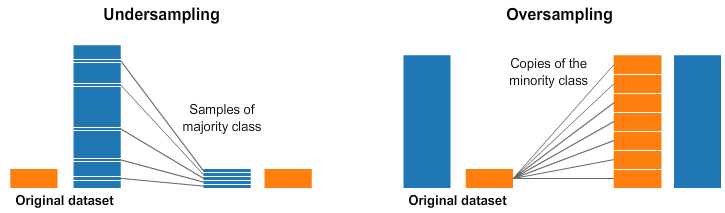

Resample by undersampling

In [69]:
run = RandomUnderSampler()
Xtrain_run, ytrain_run = run.fit_resample(Xtrain_out, y_train)

# summarize the new class distribution
print('Before:')
counter = Counter(y_train)
print(counter)
print('After:')
counter = Counter(ytrain_run)
print(counter)

Before:
Counter({0: 3298909, 1: 282490})
After:
Counter({0: 282490, 1: 282490})


Resample by oversampling

In [70]:
rov = RandomOverSampler()
Xtrain_rov, ytrain_rov = rov.fit_resample(Xtrain_out, y_train)

# summarize the new class distribution
print('Before:')
counter = Counter(y_train)
print(counter)
print('After:')
counter = Counter(ytrain_rov)
print(counter)

Before:
Counter({0: 3298909, 1: 282490})
After:
Counter({0: 3298909, 1: 3298909})


We've come to the end of our feature engineering. We have three training data sets, one validation set and one test set.
* **Training sets :** 
 
  * Xtrain_out - No resampling done || Target -> y_train
  * Xtrain_run - undersampling done  || Target -> ytrain_run 
  * Xtrain_rov - oversampling done   || Target -> ytrain_rov

* **Validation set :**
  
  *  Xtest_out - No resampling done  || Target -> y_test

* **Test set :**

  *   testdf_out - No resampling done || Target -> None. We predict it!

<a id="five"></a>
## **5. Modeling**
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Here,  the modelling works begins.

In these phase we will train our model with both the Imbalanced dataset and Balanced dataset, so as to compare the results.

We will be training  the below models using our already processed data.
* Logistic Regression
* Decision Tree Classifier
* Support Vector Machine classifier: 
* Guassian Naive Bayes Classifier

### Ensemble Models
* Random Forest Classifier.
* Bagging Classifier

Lets now train and compare the above models to see the one with the best fit for predictions using their default parameters.

But first lets give a brief overview of our models:

* 1. Logistic Regression: is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. Despite having “regression” in its name, a logistic regression is actually a widely used binary classifier (i.e., the target vector can only take two values). In a logistic regression, a linear model (e.g., β0 + β1x) is included in a logistic (also called sigmoid) function, (1 / (1 + e^-z)), 
such that : P(yi = 1 | X) = 1 / (1 + e^-(β0 and β1x))

where P(yi = 1 | X) is the probability of the ith observation’s target value, yi, being class 1, X is the training data, β0 and β1 are the parameters to be learned, and e is Euler’s number. The effect of the logistic function is to constrain the value of the function’s output to between 0 and 1 so that it can be interpreted as a probability. If P(yi = 1 | X) is greater than 0.5, class 1 is predicted; otherwise, class 0 is predicted.

* 2. Decision Tree: Tree-based learning algorithms are a broad and popular family of related nonparametric, supervised methods for both classification and regression. The basis of tree-based learners is the decision tree wherein a series of decision rules (e.g., “If their gender is male…”) are chained. The result looks vaguely like an upside-down tree, with the first decision rule at the top and subsequent decision rules spreading out below. In a decision tree, every decision rule occurs at a decision node, with the rule creating branches leading to new nodes. A branch without a decision rule at the end is called a leaf.
Decision tree learners attempt to find a decision rule that produces the greatest decrease in impurity at a node, by default decision tree classifier uses gini imourity, but using exhaustive search we select the best learner for the model by searching ovar a range of hyperparameters. This model uses *ENTROPY* as its base learner: where entropy is the measures of information contained in a state. I f entropy is high then we are very uncertain about the randomly picked points.

Simply put, the model considers every possible splits and takes the one that maximizes the information gain.

* 3. Support Vector Machine: Support vector machines classify data by finding the hyperplane that maximizes the margin between the classes in the training data. In a two-dimensional example with two classes, we can think of a hyperplane as the widest straight “band” (i.e., line with margins) that separates the two classes.

* 4. Guassian Naive Bayes: The most common type of naive Bayes classifier is the Gaussian naive Bayes. In Gaussian naive Bayes, we assume that the likelihood of the feature values, x, given an
observation is of class y, follows a normal distribution.

* 5. Random Forest: A common problem with decision trees is that they tend to fit the training data too closely (i.e., overfitting). This has motivated the widespread use of an ensemble learning method called random forest. In a random forest, many decision trees are trained, but each tree only receives a bootstrapped sample of observations (i.e., a random sample of observations with replacement that matches the original number of observations) and each node only considers a subset of features when determining the best split. This forest of randomized decision trees (hence the name) votes to determine the predicted class

* 6. Bagging(Decision Tree): A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

Give names to the models

Instantiate the models with default parameters

In [81]:
# Give names to the models
names = ['LR', 'DTree', 'SVM', 'MNB', 'RF', 'bag_model']

# Instantiate the models.
classifiers = [
    LogisticRegression(),
    tree.DecisionTreeClassifier(max_depth=None, criterion='entropy'),
    GaussianNB(),
    SGDClassifier(),
    RandomForestClassifier(),
    BaggingClassifier(
        base_estimator=tree.DecisionTreeClassifier(max_depth=None, criterion='entropy'),
        n_estimators=10,
        max_samples=0.6,
        oob_score=True,
        random_state=42
        )
]

No resampled data Modelling

In [72]:
results = []
models = {}
for name, clf in zip(names, classifiers):
    print('Fitting {:s} model.....'.format(name))
    # We train each model using .fit 
    start = time.time()
    clf.fit(Xtrain_out, y_train)
    stop =  time.time()
    
    
    #Predict the Target Class with the below code using .predict
    print('..... Predicting')
    y_pred = clf.predict(Xtest_out)
    train_pred = clf.predict(Xtrain_out)
    
    #Score the models with the accuracy and F1_score.
    print('..... Scoring')
    accuracy = accuracy_score(y_test, y_pred) # Test Accuracy
    f1_Score = f1_score(y_test, y_pred, average='macro')
    train_f1_Score = f1_score(y_train, train_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    #Save the results to dictionaries
    models[name] = clf
    train_time = np.round((stop - start)/60, 2)
    
    results.append([name, accuracy, f1_Score, train_f1_Score, precision, recall, train_time])
    print('..... {:s} model Completed .....'.format(name))
    
#Creating a df from the results    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy Score', 'F1 Score', 'Train F1 Score', 'Precision', 'Recall', 'Train_Time'])
results.set_index('Classifier', inplace=True)
print('!!!!!!!!!ALL Done!!!!!!!!!!!')

#Classification Report
no_y_pred = np.around(models['DTree'].predict(Xtest_out))
no_DTree_class = classification_report(y_test, no_y_pred)

no_y_pred = np.around(models['bag_model'].predict(Xtest_out))
no_bag_model_class = classification_report(y_test, no_y_pred)

Fitting LR model.....
..... Predicting
..... Scoring
..... LR model Completed .....
Fitting DTree model.....
..... Predicting
..... Scoring
..... DTree model Completed .....
Fitting SVM model.....
..... Predicting
..... Scoring
..... SVM model Completed .....
Fitting MNB model.....
..... Predicting
..... Scoring
..... MNB model Completed .....
Fitting RF model.....
..... Predicting
..... Scoring
..... RF model Completed .....
Fitting bag_model model.....
..... Predicting
..... Scoring
..... bag_model model Completed .....
!!!!!!!!!ALL Done!!!!!!!!!!!


Saving Models in a pickle file

In [73]:
# model_save_path = "bagging_model.pkl"
# with open(model_save_path,'wb') as file:
#     pickle.dump(models['bag_model'],file)

UnderSampled Data Modelling

In [77]:
rus_results = []
rus_models = {}
for name2, clf2 in zip(names, classifiers):
    print('Fitting {:s} model.....'.format(name2))
    # We train each model using .fit 
    start = time.time()
    clf2.fit(Xtrain_run, ytrain_run)
    stop =  time.time()
    
    
    #Predict the Target Class with the below code using .predict
    print('..... Predicting')
    y_pred = clf2.predict(Xtest_out)
    train_pred = clf2.predict(Xtrain_run)
    
    #Score the models with the accuracy and F1_score.
    print('..... Scoring')
    accuracy = accuracy_score(y_test, y_pred) # Test Accuracy
    f1_Score = f1_score(y_test, y_pred, average='macro')
    train_f1_Score = f1_score(ytrain_run, train_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    #Save the results to dictionaries
    rus_models[name2] = clf2
    train_time = np.round((stop - start)/60, 2)
    
    rus_results.append([name2, accuracy, f1_Score, train_f1_Score, precision, recall, train_time])
    print('..... {:s} model Completed .....'.format(name2))
    
#Creating a df from the results    
rus_results = pd.DataFrame(rus_results, columns=['Classifier', 'Accuracy Score', 'F1 Score', 'Train F1 Score', 'Precision', 'Recall', 'Train_Time'])
rus_results.set_index('Classifier', inplace=True)
print('!!!!!!!!!ALL Done!!!!!!!!!!!')

#Classification Report
us_y_pred = np.around(rus_models['DTree'].predict(Xtest_out))
us_DTree_class = classification_report(y_test, no_y_pred)

us_y_pred = np.around(rus_models['bag_model'].predict(Xtest_out))
us_bag_model_class = classification_report(y_test, no_y_pred)


Fitting LR model.....
..... Predicting
..... Scoring
..... LR model Completed .....
Fitting DTree model.....
..... Predicting
..... Scoring
..... DTree model Completed .....
Fitting SVM model.....
..... Predicting
..... Scoring
..... SVM model Completed .....
Fitting MNB model.....
..... Predicting
..... Scoring
..... MNB model Completed .....
Fitting RF model.....
..... Predicting
..... Scoring
..... RF model Completed .....
Fitting bag_model model.....
..... Predicting
..... Scoring
..... bag_model model Completed .....
!!!!!!!!!ALL Done!!!!!!!!!!!


OverSampled Data Modelling.

In [82]:
ros_results = []
ros_models = {}
for name3, clf3 in zip(names, classifiers):
    print('Fitting {:s} model.....'.format(name3))
    # We train each model using .fit 
    start = time.time()
    clf3.fit(Xtrain_rov, ytrain_rov)
    stop =  time.time()
    
    
    #Predict the Target Class with the below code using .predict
    print('..... Predicting')
    y_pred = clf3.predict(Xtest_out)
    train_pred = clf3.predict(Xtrain_rov)
    
    #Score the models with the accuracy and F1_score.
    print('..... Scoring')
    accuracy = accuracy_score(y_test, y_pred) # Test Accuracy
    f1_Score = f1_score(y_test, y_pred, average='macro')
    train_f1_Score = f1_score(ytrain_rov, train_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    #Save the results to dictionaries
    ros_models[name3] = clf3
    train_time = np.round((stop - start)/60, 2)
    
    ros_results.append([name3, accuracy, f1_Score, train_f1_Score, precision, recall, train_time])
    print('..... {:s} model Completed .....'.format(name3))
    
#Creating a df from the results    
ros_results = pd.DataFrame(ros_results, columns=['Classifier', 'Accuracy Score', 'F1 Score', 'Train F1 Score', 'Precision', 'Recall', 'Train_Time'])
ros_results.set_index('Classifier', inplace=True)
print('!!!!!!!!!ALL Done!!!!!!!!!!!')

#Classification Report
os_y_pred = np.around(ros_models['DTree'].predict(Xtest_out))
os_DTree_class = classification_report(y_test, no_y_pred)

os_y_pred = np.around(ros_models['bag_model'].predict(Xtest_out))
os_bag_model_class = classification_report(y_test, no_y_pred)

Fitting LR model.....
..... Predicting
..... Scoring
..... LR model Completed .....
Fitting DTree model.....
..... Predicting
..... Scoring
..... DTree model Completed .....
Fitting SVM model.....
..... Predicting
..... Scoring
..... SVM model Completed .....
Fitting MNB model.....
..... Predicting
..... Scoring
..... MNB model Completed .....
Fitting RF model.....
..... Predicting
..... Scoring
..... RF model Completed .....
Fitting bag_model model.....
..... Predicting
..... Scoring
..... bag_model model Completed .....
!!!!!!!!!ALL Done!!!!!!!!!!!


<a id="six"></a>
## **6. Model Performance**
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

For our model performance we will consider the following metrics - Accuracy, Precision, Recall and F1-score.

### Accuracy
Accuracy is a common performance metric. It is simply the proportion of observations predicted correctly:

    * Accuracy =  TP + TN / TP + TN + FP + FN
where:
* TP is the number of true positives. Observations that are part of the positive class (clients that do not commit fraud) and that we predicted correctly.
* TN is the number of true negatives. Observations that are part of the negative class (clients that commit fraud) and that we predicted correctly.
* FP is the number of false positives. Also called a Type I error. Observations predicted to be part of the positive class that are actually part of the negative class.
* FN is the number of false negatives. Also called a Type II error. Observations predicted to be part of the negative class that are actually part of the positive class.

The appeal of accuracy is that it has intuitive and plain English explanation: proportion of observations predicted correctly. However, in the real world, often our data has imbalanced classes. When in the presence of imbalanced classes, accuracy suffers from a paradox where a model is highly accurate but lacks predictive power.

For this reason, we are often motivated to use other metrics like precision, recall, and F1 score.

### Precision
Precision answers the question of “what proportion of predicted positives in a class are truly postitive in that class?.

    * Precision =  TP / TP + FP

We can think about it as a measurement noise in our predictions - that is, when we predict something is positive, how likely we are to be right. Models with high precision are *pessimistic* in that they only predict an observation is of the positive class when they are very certain about it.

### Recall
When the outcome is actually yes, how often do we predict it as such?

    * Precision =  TP / TP + FN
Recall measures the model’s ability to identify an observation of the positive class. Models with high recall are *optimistic* in that they have a low bar for predicting that an observation is in the positive class.

### F1-Score

It is calculated by taking the *harmonic mean of precision and recall* and ranges from 0 to 1. It is a more robust measure especially for imbalanced data.
Almost always we want some kind of balance between precision and recall, and this role is filled by the F1 score. The F1 score is the harmonic mean (a kind of average used for ratios):

    * F1-Score = 2 × Precision × Recall Precision + Recall

It is a measure of correctness achieved in positive prediction—that is, of observations labeled as positive, how many are actually positive.

Lets have a view of how our model performed based on the sampling differences.

No sampling data results

In [73]:
results.sort_values('F1 Score', ascending=False)

,Accuracy Score,F1 Score,Train F1 Score,Precision,Recall,Train_Time
Classifier,,,,,,
DTree,0.953972,0.841764,0.998469,0.841457,0.842072,1.55
bag_model,0.961187,0.837022,0.953724,0.939215,0.777781,8.03
RF,0.945051,0.727334,0.997962,0.939800,0.662174,18.90
LR,0.921145,0.481042,0.480864,0.734014,0.500730,0.87
MNB,0.921124,0.479471,0.479471,0.460562,0.500000,0.22
SVM,0.179671,0.178797,0.179033,0.517375,0.523691,0.10


Looking at the above table, apart from the Support Vector Machine (SVM), all other classification models has a very high *accuracy score*, an above 90 percent accuracy, simply tells us that above 90 percent of the time our model prediction is accurate, that's true, but in these case of imbalance data, where the *non_fraud* cases is over 90% of our dataset, we cannot infer the predictive ability of the model in predicting *fraud* cases. 

Now lets discuss the *Precision* and *Recall* for each model:
Decision Tree: with a precision and recall score of 0.84, the decision tree model can predict *non fraud* cases 84% of the time, and 84% of the time the prediction of *non fraud* cases is actually correct.

Bag_model using decision tree as the base model, we saw an high precision score of 0.94, 10% higher that decision tree classifier, but a lower recall score of 0.78 -- this simple means that the model predicts *non-fraud* 94% of the time, only 78% are actually *non fraud* cases.

Random Forest: we can also see that the model has an high precision score of 0.94 and are more lower recall score of 0.66, stating for every non-fraud cases predicting only 66% is actually accurately predicted as non-fraud.

Now based on research, selecting the best model in a situation of imbalanced data, requires the use of f1_score which has been proven to be the best metric for model performance.
In regards to that, out of the six different models being trained on the available, the Decision Tree classifier has the higher F1 score of 0.84 while the Support vector Machine classifier performed extremelly poor with with an f1 score of 0.18. 

Having Selected Decision Tree classifier as the best model: the overfittng problem in which a decision tree model are commonly prone to must be discussed.
* Q1. Does our Decision Tree Classifier model as an overfitting problem: YES.
* Q2. What method was used to reduce the overfittng problem: emsemble models : Random Forest and Bagging.

Using the Random Forest classifier, the model was greatly overfitted compared to the single decision tree model, while the bagging model using the decision tree classifier as the base classifier actually reduced the overfitting problem, but lead to another issue of training time.



No Sampling data classification_report

Now using a classification report to differentiate between the Decision tree classifier and the bagging model classifier

In [74]:
print('Nosampled Classification Report for Decision Tree Classifier \n', no_DTree_class)
print('Nosampled Classification Report for Bagging Classifier \n', no_bag_model_class)

Nosampled Classification Report for Decision Tree Classifier 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98    824728
           1       0.71      0.71      0.71     70622

    accuracy                           0.95    895350
   macro avg       0.84      0.84      0.84    895350
weighted avg       0.95      0.95      0.95    895350

Nosampled Classification Report for Bagging Classifier 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    824728
           1       0.91      0.56      0.69     70622

    accuracy                           0.96    895350
   macro avg       0.94      0.78      0.84    895350
weighted avg       0.96      0.96      0.96    895350



From the report above, the decision tree model and the bagging model as the same f1 score of 0.98 for the *non fraud cases*, but for *fraud cases* the decision tree classifier performed better with an f1 score of 0.71, while the bagging model has as f1 score of 0.69.

Lets plots the time difference

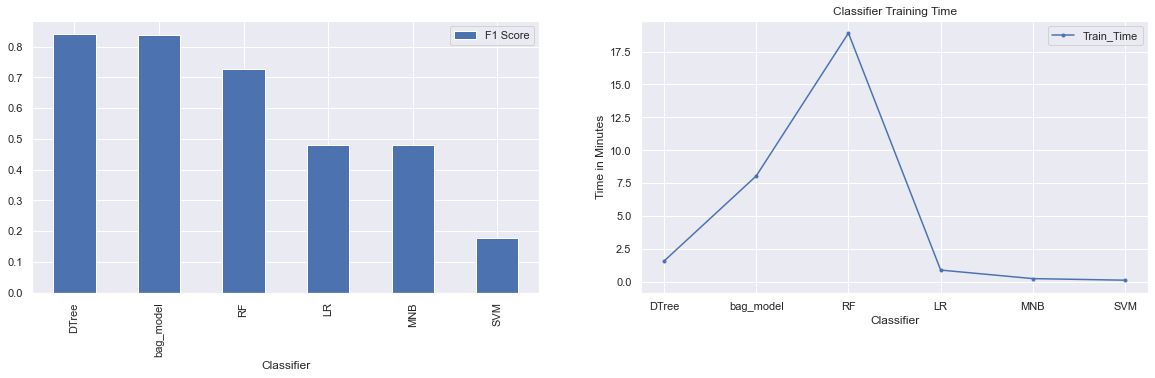

In [75]:
#results['F_Measure'] = results['F1 Score'] * 100
#results['Train_mins'] = results['Train_Time']/60

fig, ax = plt.subplots(1,2, figsize =(20,5))
results.sort_values('F1 Score', ascending=False, inplace=True)
results.plot(y='F1 Score', kind='bar', ax=ax[0])
plt.xticks(rotation=90)
plt.title('Classifier F1 Score (%)');
results.plot(y='Train_Time', kind='line', marker='.', ax=ax[1])
plt.ylabel('Time in Minutes')
plt.title('Classifier Training Time');

In an industry settings where time is of the outmost importance, and looking at the performance of the models, we can therefore select the decision tree classifier model as simple the best model for the use case, compared to the second best with less underfitting issue but with a more longer training time.

Now based on undersample data let see if there is any improvement in the model.

Undersampled data results

In [78]:
rus_results.sort_values('F1 Score', ascending=False)

,Accuracy Score,F1 Score,Train F1 Score,Precision,Recall,Train_Time
Classifier,,,,,,
bag_model,0.866816,0.713555,0.978174,0.671501,0.862775,1.18
RF,0.846594,0.693023,0.999538,0.656994,0.863243,2.40
DTree,0.827483,0.668003,0.999538,0.639779,0.838673,0.19
LR,0.624510,0.478018,0.612610,0.534646,0.613588,0.14
MNB,0.601829,0.460048,0.585834,0.525789,0.585779,0.06
SVM,0.219459,0.214650,0.455033,0.515551,0.528347,0.01


UnderSampled data classification_report

In [79]:
print('Undersample Data Classification Report for Decision Tree Classifier \n', us_DTree_class)
print('Undersample Data Classification Report for Bagging Classifier \n', us_bag_model_class)

Undersample Data Classification Report for Decision Tree Classifier 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    824728
           1       0.91      0.56      0.69     70622

    accuracy                           0.96    895350
   macro avg       0.94      0.78      0.84    895350
weighted avg       0.96      0.96      0.96    895350

Undersample Data Classification Report for Bagging Classifier 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    824728
           1       0.91      0.56      0.69     70622

    accuracy                           0.96    895350
   macro avg       0.94      0.78      0.84    895350
weighted avg       0.96      0.96      0.96    895350



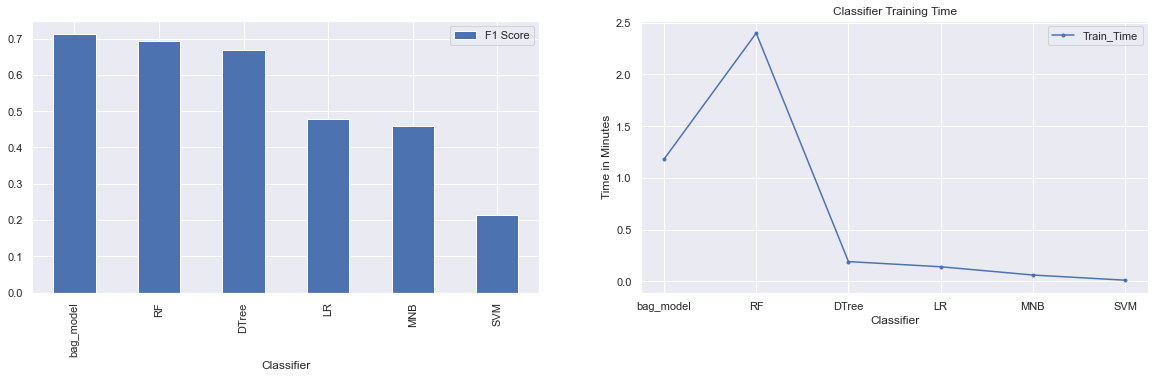

In [80]:
#results['F_Measure'] = results['F1 Score'] * 100
#rus_results['Train_mins'] = rus_results['Train_Time']/60

fig, ax = plt.subplots(1,2, figsize =(20,5))
rus_results.sort_values('F1 Score', ascending=False, inplace=True)
rus_results.plot(y='F1 Score', kind='bar', ax=ax[0])
plt.xticks(rotation=90)
plt.title('')
rus_results.plot(y='Train_Time', kind='line', marker='.', ax=ax[1])
plt.ylabel('Time in Minutes');
plt.title('Classifier Training Time');

Overall the tree based models are still the best but training on a limited data has reduced there performance. so based on the above informations is not advisable. Meaning the more data available, the more our model performance increases.

Now lets see if our model performed better using the oversample class data.

Oversampled data results

In [83]:
ros_results.sort_values('F1 Score', ascending=False)

,Accuracy Score,F1 Score,Train F1 Score,Precision,Recall,Train_Time
Classifier,,,,,,
bag_model,0.965435,0.878032,0.998355,0.888005,0.868667,73.13
DTree,0.953531,0.839135,0.999527,0.841207,0.837094,2.28
RF,0.952854,0.796372,0.999526,0.906937,0.738145,31.13
LR,0.624834,0.478049,0.612560,0.534522,0.613123,1.49
MNB,0.602175,0.460141,0.585973,0.525721,0.585519,0.49
SVM,0.169748,0.169359,0.420730,0.517186,0.521386,0.15


Oversampled data classification_report

In [84]:
print('Oversample Data Classification Report for Decision Tree Classifier \n', os_DTree_class)
print('Oversample Data Classification Report for Bagging Classifier \n', os_bag_model_class)

Oversample Data Classification Report for Decision Tree Classifier 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    824728
           1       0.91      0.56      0.69     70622

    accuracy                           0.96    895350
   macro avg       0.94      0.78      0.84    895350
weighted avg       0.96      0.96      0.96    895350

Oversample Data Classification Report for Bagging Classifier 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    824728
           1       0.91      0.56      0.69     70622

    accuracy                           0.96    895350
   macro avg       0.94      0.78      0.84    895350
weighted avg       0.96      0.96      0.96    895350



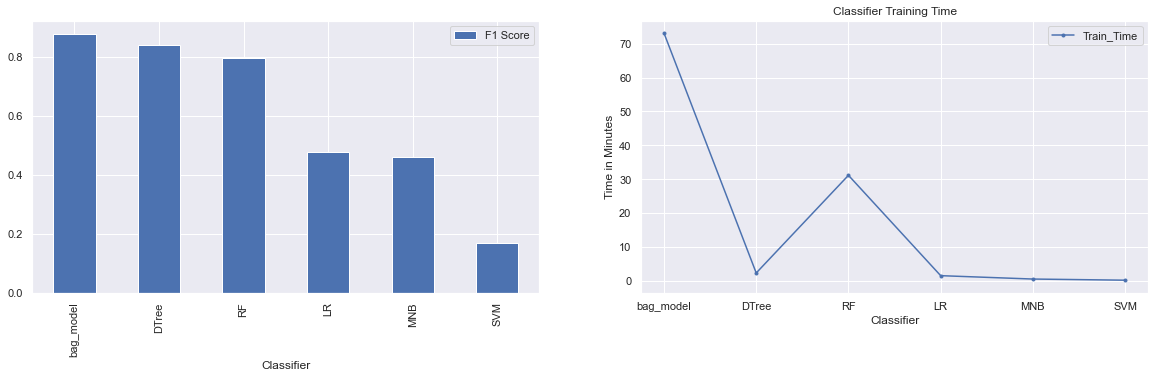

In [85]:
#results['F_Measure'] = results['F1 Score'] * 100
#ros_results['Train_mins'] = ros_results['Train_Time']/60

fig, ax = plt.subplots(1,2, figsize =(20,5))
ros_results.sort_values('F1 Score', ascending=False, inplace=True)
ros_results.plot(y='F1 Score', kind='bar', ax=ax[0])
plt.xticks(rotation=90)
plt.title('')
ros_results.plot(y='Train_Time', kind='line', marker='.', ax=ax[1])
plt.ylabel('Time in Minutes');
plt.title('Classifier Training Time');

We can note a slight improvement in the models, having seen the bagging classifier model increased f1 score of 0.88, but the performance is not as significant as we would what to expect, giving an massive increase in the training time.

Therefore in all test conducted above, the decision tree classifier model simply outbest the other model based on predictive capability and als the speed.

So our best model is the decision tree classifier.

In [84]:
# # Instantiate the models with 'criterion': 'entropy', 'max_depth': None
# dtree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=None)
# dtree.fit(Xtrain_rov, ytrain_rov)

DecisionTreeClassifier(criterion='entropy')

In [86]:
# DT_y_pred = np.around(dtree.predict(Xtest_out))
# print('Hyperparameter Tunning with entropy \n',classification_report(y_test, DT_y_pred))

Hyperparameter Tunning with entropy               precision    recall  f1-score   support

           0       0.97      0.98      0.98    824728
           1       0.71      0.70      0.71     70622

    accuracy                           0.95    895350
   macro avg       0.84      0.84      0.84    895350
weighted avg       0.95      0.95      0.95    895350



In [90]:
# dtree.get_feature_importance()

AttributeError: 'DecisionTreeClassifier' object has no attribute 'get_feature_importance'

Bagging with Decision tree as base model

In [88]:
# bag_model = BaggingClassifier(
#     base_estimator=tree.DecisionTreeClassifier(criterion='entropy', max_depth=None),
#     n_estimators=100,
#     max_samples=0.8,
#     oob_score=True,
#     random_state=0
# )

# bag_model.fit(Xtrain_rov, ytrain_rov)
# bag_model.oob_score_

0.9931453095553712

In [89]:
# bag_y_pred = np.around(bag_model.predict(Xtest_out))
# print('Bagging Model \n',classification_report(y_test, bag_y_pred))

Bagging Model 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98    824728
           1       0.83      0.77      0.80     70622

    accuracy                           0.97    895350
   macro avg       0.90      0.88      0.89    895350
weighted avg       0.97      0.97      0.97    895350



AdaBoosting with Decision tree as base model

In [59]:
# ada = AdaBoostClassifier(
#     base_estimator=tree.DecisionTreeClassifier(criterion='entropy', max_depth=None),
#     n_estimators=8,
#     learning_rate=0.2,
#     random_state=42
# )

# ada.fit(Xtrain_rov, ytrain_rov)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.2, n_estimators=8, random_state=42)

In [60]:
# ada_y_train_pred = ada.predict(Xtrain_rov)
# ada_y_test_pred = ada.predict(Xtest_out)

# ada_train = f1_score(ytrain_rov, ada_y_train_pred)
# ada_test = f1_score(y_test, ada_y_test_pred)

# print(f"Adaboost train/test accuracies: {ada_train:.3f}/{ada_test:.3f}")

Adaboost train/test accuracies: 1.000/0.614


In [ ]:
# svm_clf = svm